In [135]:
!pip install -q pyyaml

In [137]:
import numpy as np 
import pandas as pd 
import os
import torch 
import matplotlib.pyplot as plt
import cv2
import random
import shutil
import copy
import yaml

# Download Data

In [9]:
# !pip install -q gdown
# !gdown --folder 18OdCMZes7MT_YuZqyCs_4QTPXt1EV4Up

Retrieving folder contents
Processing file 1BQvwhSoeDm-caCImtlbcAMzhI8MDsrCZ public test.zip
Processing file 1hQEdcxg8WgG3mkoCRjuBimljQQD5a3aa train.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1BQvwhSoeDm-caCImtlbcAMzhI8MDsrCZ
From (redirected): https://drive.google.com/uc?id=1BQvwhSoeDm-caCImtlbcAMzhI8MDsrCZ&confirm=t&uuid=369de457-8820-40a0-8bb4-a07472660587
To: /kaggle/working/Traffic Vehicle Detection/public test.zip
100%|█████████████████████████████████████████| 142M/142M [00:00<00:00, 151MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hQEdcxg8WgG3mkoCRjuBimljQQD5a3aa
From (redirected): https://drive.google.com/uc?id=1hQEdcxg8WgG3mkoCRjuBimljQQD5a3aa&confirm=t&uuid=21945796-890f-4c80-97d1-dca82687aa20
To: /kaggle/working/Traffic Vehicle Detection/train.zip
100%|███████████████████████████████████████| 1.40G/1.40G [00:05<00:00, 259MB

In [10]:
# %cd /kaggle/working/Traffic Vehicle Detection
# !unzip -q '*.zip' -d ./

/kaggle/working/Traffic Vehicle Detection

2 archives were successfully processed.


# About data

## Data Architecture, Types Of Files

In [21]:
%cd /kaggle/working/Traffic Vehicle Detection
print(len(os.listdir("train")), '||', os.listdir("train")[0], '||', os.listdir("train")[1])
print(len(os.listdir("public test")), '||', os.listdir("public test")[0], '||', os.listdir("public test")[1])
print(len(os.listdir("nighttime")), '||', os.listdir("nighttime")[0], '||', os.listdir("nighttime")[1])
print(len(os.listdir("daytime")), '||', os.listdir("daytime")[0], '||', os.listdir("daytime")[1])

/kaggle/working/Traffic Vehicle Detection
23042 || cam_06_00867.txt || cam_08_00423_jpg.rf.444b230ddb1f0225acb9f24ca786753a.jpg
2060 || cam_10_00618.jpg || cam_08_00557_jpg.rf.f3ff6dc42ff8bbc2f12bffe5ffb05ece.jpg
9258 || cam_08_00423_jpg.rf.444b230ddb1f0225acb9f24ca786753a.jpg || cam_03_00801_jpg.rf.01f5fa49dbb0c722cd65d1a45cd154e8.txt
23042 || cam_06_00867.txt || cam_08_00423_jpg.rf.444b230ddb1f0225acb9f24ca786753a.jpg


In [24]:
def count_txt_jpg(folder):
    count_txt, count_jpg = 0, 0 
    
    for file in os.listdir(folder):
        if ".txt" in file:
            count_txt += 1
        elif ".jpg" in file:
            count_jpg += 1
    return count_txt, count_jpg

# daytime_txt, daytime_jpg = count_txt_jpg("daytime")
# print(f"Daytime: {daytime_txt} txt files, {daytime_jpg} jpg files\n")

# nighttime_txt, nighttime_jpg = count_txt_jpg("nighttime")
# print(f"Nighttime: {nighttime_txt} txt files, {nighttime_jpg} jpg files\n")

# train_txt, train_jpg = count_txt_jpg("train")
# print(f"Train: {train_txt} txt files, {train_jpg} jpg files\n")

# test_txt, test_jpg = count_txt_jpg("public test")
# print(f"Test: {test_txt} txt files, {test_jpg} jpg files\n")

Daytime: 11521 txt files, 11521 jpg files

Nighttime: 4629 txt files, 4629 jpg files

Train: 11521 txt files, 11521 jpg files

Test: 0 txt files, 2060 jpg files



In [53]:
"""
    Train = Daytime
    all files in Nighttime at train

    => I ONLY NEED TO CARE ABOUT TRAIN SET:
    IN TRAIN SET:
        ".rf" file is the picture - annotation

        4629 night-time pictures
        6892 day-time pictures
"""

# y = {x : 1 for x in os.listdir("train")}
# z = 0

# for file in os.listdir("nighttime"):
#     x = y.get(file, -1)
#     if x != -1:
#         z += 1
#     else:
#         print(file)
# print(z/2)

# count_rf = 0
# for file in os.listdir("/kaggle/working/Traffic Vehicle Detection/train"):
#     if ".rf" in file:
#         count_rf += 1

# print(count_rf/2)

4166.0


In [38]:
# !rm -rf "/kaggle/working/Traffic Vehicle Detection/daytime"
# !rm -rf "/kaggle/working/Traffic Vehicle Detection/nighttime"

## Split Train to Train/Val

In [53]:
os.mkdir("val")

In [47]:
# night_imgs, num_night_imgs = [], 463 # 463 imgs
# day_imgs, num_day_imgs = [], 689 # 689 imgs

# for file in os.listdir("train"):
#     if ".jpg" in file:
#         if ".rf" in file:
#             night_imgs.append(file)
#         else:
#             day_imgs.append(file)

In [57]:
def move(imgs, num_imgs):
    random.shuffle(imgs)
    val_imgs = imgs[:num_imgs]
    val_txts = [img.replace(".jpg", ".txt") for img in val_imgs]

    for id in range(num_imgs):
        img, txt = val_imgs[id], val_txts[id]
        
        shutil.move(os.path.join("train", img), "val")
        shutil.move(os.path.join("train", txt), "val")

# move(night_imgs, num_night_imgs)
# move(day_imgs, num_day_imgs)

### Visualizer

In [9]:
%cd /kaggle/working/Traffic Vehicle Detection
"""
    label type in .txt file: [label, x_center, y_center, width, height]. 
    #all values are being normalized
"""

/kaggle/working/Traffic Vehicle Detection


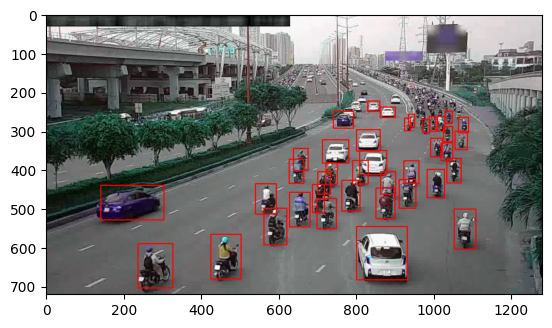

In [15]:
image_path = os.path.join("val", 'cam_09_00655.jpg')
txt_path = os.path.join("val", "cam_09_00655.txt")

image = cv2.imread(image_path)
height, width, channel = image.shape # height, width, channel

with open(txt_path, "r") as file:
    boxes = file.readlines() # list of string of boxes
    
# get real values of boxes
def get_values_from_string(line):
    line = line.strip().replace("\n", "").split(' ')
    label, x_center, y_center, width, height = int(line[0]), float(line[1]), float(line[2]), \
                                          float(line[3]), float(line[4])
    return [label, x_center, y_center, width, height]

real_boxes = [get_values_from_string(line) for line in boxes]
for box in real_boxes:
    x_center, y_center, norm_width, norm_height = box[1:]
    x_left = x_center - norm_width/2; y_left = y_center - norm_height/2
    x_right = x_center + norm_width/2; y_right = y_center + norm_height/2
    
    image = cv2.rectangle(image,
                          (int(x_left*width), int(y_left*height)),
                          (int(x_right*width), int(y_right*height)),
                          color = (255, 0, 0),
                          thickness = 2)
plt.imshow(image)

## Explore Boxes/Labels

### Fix labels (night img) to standard

In [50]:
def fix_labels_rf_txt(folder):
    num_txt_need_fix = 0
    
    for file in os.listdir(folder):
        if ".rf" in file and ".txt" in file:
            num_txt_need_fix += 1
            path = os.path.join(folder, file)
            
            with open(path, "r") as file:
                boxes = file.readlines() # list of string of boxes
                
            new_boxes = []
            for line in boxes:
                new_line = str(int(line[0]) - 4) + line[1:]
                new_boxes.append(new_line)
            
            with open(path, "w") as file:
                for line in new_boxes:
                    file.write(line)
                    
    return num_txt_need_fix

In [89]:
# print("Train: ", fix_labels_rf_txt("/kaggle/working/Traffic Vehicle Detection/train"))
# print("Val: ", fix_labels_rf_txt("/kaggle/working/Traffic Vehicle Detection/val"))

In [87]:
wrong = []

for path in paths:
    with open(path, "r") as file:
        boxes = file.readlines() # list of string of boxes
    for line in boxes:
        try:
            if '3' < line[0] or line[0] < '0':
                wrong.append(path)
                break
        except:
            print(path)

### Labels Exploration

In [115]:
labels = {i : 0 for i in range(4)}

for file in os.listdir("/kaggle/working/Traffic Vehicle Detection/train"):
    if ".txt" in file:
        with open(os.path.join("/kaggle/working/Traffic Vehicle Detection/train", file), "r") as file:
            boxes = file.readlines()
        for line in boxes:
            labels[int(line[0])] += 1

### Small, Medium, Large Imgs Exploration

In [124]:
img_sizes = {
    "small": 0,
    "medium": 0,
    "large": 0
} 

def get_values_from_string(line):
    line = line.strip().replace("\n", "").split(' ')
    label, x_center, y_center, width, height = int(line[0]), float(line[1]), float(line[2]), \
                                          float(line[3]), float(line[4])
    return [label, x_center, y_center, width, height]

for filename in os.listdir("/kaggle/working/Traffic Vehicle Detection/train"):
    if ".txt" in filename and ".rf" not in filename:
        with open(os.path.join("/kaggle/working/Traffic Vehicle Detection/train", filename), "r") as file:
            boxes = file.readlines()

        image_path = os.path.join("/kaggle/working/Traffic Vehicle Detection/train", 
                                  filename.replace(".txt", ".jpg"))
        try:
            image = cv2.imread(image_path)
            height, width, channel = image.shape # height, width, channel
                
            real_boxes = [get_values_from_string(line) for line in boxes]
            for box in real_boxes:
                x_center, y_center, norm_width, norm_height = box[1:]
                
                x_left = (x_center - norm_width/2)*width; y_left = (y_center - norm_height/2)*height
                x_right = (x_center + norm_width/2)*width; y_right = (y_center + norm_height/2)*height
                area = (x_right - x_left)*(y_right-y_left)
                
                if area < 32**2:
                    img_sizes["small"] += 1
                elif area < 96**2:
                    img_sizes["medium"] += 1
                else:
                    img_sizes["large"] += 1
        except:
            print(image_path)

### Summary:
### Num Images:
    1. Day: 6203
    2. Night: 4166
    
#### Night Time:
    1. About sizes: 
        - 'small': 2317 boxes, 
        - 'medium': 18290 boxes, 
        - 'large': 5887 boxes
        
    2. About labels:
        - Label 0: 14279 boxes
        - Label 1: 7523 boxes
        - Label 2: 2169 boxes
        - Label 3: 2523 boxes
        
#### Day Time:
    1. About sizes: 
        - 'small': 16278 boxes, 
        - 'medium': 60805 boxes, 
        - 'large': 12112 boxes
        
    2. About labels:
        - Label 0: 59093 boxes 
        - Label 1: 15813 boxes
        - Label 2: 3626 boxes
        - Label 3: 10663 boxes

# Convert raw data to YOLO/COCO type

In [128]:
%cd /kaggle/working/
!mkdir yolo_dataset
!mkdir rtdetr_dataset

/kaggle/working


In [129]:
%cd yolo_dataset
!mkdir train
!mkdir ./train/labels
!mkdir ./train/images

!mkdir val
!mkdir ./val/labels
!mkdir ./val/images

/kaggle/working/yolo_dataset


In [130]:
old_train_folder = "/kaggle/working/Traffic Vehicle Detection/train"
old_val_folder = "/kaggle/working/Traffic Vehicle Detection/val"

new_train_folder = "/kaggle/working/yolo_dataset/train"
new_val_folder = "/kaggle/working/yolo_dataset/val"

def copy_from_outside_to_yolo(old_train_folder, new_train_folder,
                              old_val_folder, new_val_folder):
    for file in os.listdir(old_train_folder):
        if ".jpg" in file:
            try:
                img_path = os.path.join(old_train_folder, file)
                txt_path = os.path.join(old_train_folder, file.replace(".jpg", ".txt"))
                
                shutil.copy(img_path, os.path.join(new_train_folder, "images"))
                shutil.copy(txt_path, os.path.join(new_train_folder, "labels"))
            except:
                print(img_path)

    for file in os.listdir(old_val_folder):
        if ".jpg" in file:
            try:
                img_path = os.path.join(old_val_folder, file)
                txt_path = os.path.join(old_val_folder, file.replace(".jpg", ".txt"))
                
                shutil.copy(img_path, os.path.join(new_val_folder, "images"))
                shutil.copy(txt_path, os.path.join(new_val_folder, "labels"))
            except:
                print(img_path)

In [131]:
# copy_from_outside_to_yolo(old_train_folder, new_train_folder,
#                               old_val_folder, new_val_folder)

In [140]:
# Define your data for the YAML file
data = {
    'train': '/kaggle/working/Traffic Vehicle Detection/train',
    'val': '/kaggle/working/Traffic Vehicle Detection/val',
    'names': {
        0: 'motor',
        1: 'car',
        2: 'bus',
        3: 'container'
    }
}

# Write the data to a YAML file
with open('/kaggle/working/yolo_dataset/config.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

print("YAML file created successfully!")

YAML file created successfully!
